In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

from time import time

In [2]:
data = pd.read_csv('retail_train.csv')  
data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                     'product_id': 'item_id'},
            inplace=True)

test_size_weeks = 3

data_train = data[data['week_no'] <  data['week_no'].max() - test_size_weeks]
data_test  = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', 
                                  aggfunc='count', 
                                  fill_value=0)

user_item_matrix = user_item_matrix.astype(float) 

sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id,25671,26081,26093,26190,26355,26426,26540,26601,26636,26691,...,17328742,17329473,17329749,17330255,17330511,17381856,17382205,17383227,17827644,17829232
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [5]:
def precision_at_k_l(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)

    bought_list = bought_list
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    
    precision = flags.sum() / len(recommended_list)
    
    return precision

In [6]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    return res

In [7]:
def get_precision_at_k_score(result, user_item_matrix, name, iterat=15, fact=100, regularizat=0.001):
    
    time_begin = time()
    
    model = AlternatingLeastSquares(factors=fact, 
                                    regularization=regularizat,
                                    iterations=iterat, 
                                    calculate_training_loss=True, 
                                    num_threads=4)

    model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
              show_progress=False)

    result[name] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

    score = result.apply(lambda row: precision_at_k_l(row[name], row['actual']), axis=1).mean()
    
    time_finish = time()
    
    return score, time_finish-time_begin, model

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
# Подбор матрицы Cui<br>
prec_5 = {}

result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [10]:
# Случайные веса

def set_random_weight(user_item_matrix):
    weights = np.random.rand(user_item_matrix.shape[0], user_item_matrix.shape[1])
    return user_item_matrix * weights

In [11]:
for i in range(1, 4):
    name = "rand_"+str(i)
    prec_5[name], time_len, _ = get_precision_at_k_score(result, set_random_weight(user_item_matrix), name, iterat=50)
    print(f"ALS {name}: {prec_5[name]:.4f} длительность: {time_len:.4f} c")

ALS rand_1: 0.1655 длительность: 641.6166 c
ALS rand_2: 0.1694 длительность: 627.9473 c
ALS rand_3: 0.1658 длительность: 651.3802 c


In [12]:
# Логарифмические веса
w_m = set_random_weight(user_item_matrix)

w_m = np.log(w_m[w_m > 0])

In [13]:
w_m = w_m.fillna(0.0)

In [14]:
name = "log"

prec_5[name], time_len, _ = get_precision_at_k_score(result, w_m, name, iterat=50)
f"ALS log: {prec_5['log']:.4f} длительность: {time_len:.4f} c"

'ALS log: 0.1283 длительность: 525.1307 c'

In [15]:
# TF-IDF взвешивание

name = "tfidf"
user_item_matrix_tfidf = tfidf_weight(user_item_matrix.T).T

prec_5[name], time_len, _ = get_precision_at_k_score(result, user_item_matrix_tfidf, name, iterat=50)
f"ALS tfidf: {prec_5['tfidf']:.4f} длительность: {time_len:.4f} c"

'ALS tfidf: 0.2269 длительность: 635.5063 c'

In [16]:
# BM25 взвешивание

name = "bm25"
user_item_matrix_bm25 = bm25_weight(user_item_matrix.T).T

prec_5[name], time_len, _ = get_precision_at_k_score(result, user_item_matrix_bm25, name, iterat=50)
f"ALS bm25: {prec_5['bm25']:.4f} длительность: {time_len:.4f} c"

'ALS bm25: 0.2167 длительность: 628.8334 c'

In [17]:
# Список результатов

for k, v in dict(sorted(prec_5.items(), key=lambda item: item[1])).items():
    print(f"Precision@5: {v:0.4f} - ALS {k}")

Precision@5: 0.1283 - ALS log
Precision@5: 0.1655 - ALS rand_1
Precision@5: 0.1658 - ALS rand_3
Precision@5: 0.1694 - ALS rand_2
Precision@5: 0.2167 - ALS bm25
Precision@5: 0.2269 - ALS tfidf


In [18]:
# Оптимизация гипперпараметров

summary_data = pd.DataFrame(data=[[0, 0, 0, 0, 0]], 
                            columns=['factors', 'regularization', 'iterations', 'time', 'precision@5'])
cnt = 0
factors = [50, 100, 150]
regularization = [0.01, 0.001, 0.0001]
iterations = [15, 50, 100]

for fact in factors:
    for reg in regularization:
        for iterat in iterations:
            name = f"ALS_{fact}_{reg}_{iterat}"
            print(f"ALS: factors {fact}, regularization {reg}, iterations {iterat}")
            score, time_len, model = get_precision_at_k_score(result, 
                                                              user_item_matrix, 
                                                              name, 
                                                              iterat=iterat, 
                                                              fact=fact, 
                                                              regularizat=reg)
            print(f"   Precision@5: {score:0.4f}, длительность: {time_len:.4f} c\n")
            summary_data.loc[cnt, ['factors', 'regularization', 'iterations', 
                                   'time', 'precision@5']] = [fact, reg, iterat, 
                                                              time_len, score]
            cnt += 1

ALS: factors 50, regularization 0.01, iterations 15
   Precision@5: 0.1883, длительность: 38.8103 c

ALS: factors 50, regularization 0.01, iterations 50
   Precision@5: 0.1895, длительность: 44.5125 c

ALS: factors 50, regularization 0.01, iterations 100
   Precision@5: 0.1920, длительность: 53.7393 c

ALS: factors 50, regularization 0.001, iterations 15
   Precision@5: 0.1913, длительность: 37.8125 c

ALS: factors 50, regularization 0.001, iterations 50
   Precision@5: 0.1897, длительность: 44.0408 c

ALS: factors 50, regularization 0.001, iterations 100
   Precision@5: 0.1932, длительность: 52.7155 c

ALS: factors 50, regularization 0.0001, iterations 15
   Precision@5: 0.1927, длительность: 37.6579 c

ALS: factors 50, regularization 0.0001, iterations 50
   Precision@5: 0.1928, длительность: 43.8561 c

ALS: factors 50, regularization 0.0001, iterations 100
   Precision@5: 0.1925, длительность: 53.4013 c

ALS: factors 100, regularization 0.01, iterations 15
   Precision@5: 0.1872, дл

In [19]:
summary_data

,factors,regularization,iterations,time,precision@5
0,50.0,0.0100,15.0,38.810313,0.188345
1,50.0,0.0100,50.0,44.512525,0.189520
2,50.0,0.0100,100.0,53.739259,0.191969
3,50.0,0.0010,15.0,37.812531,0.191283
4,50.0,0.0010,50.0,44.040785,0.189716
5,50.0,0.0010,100.0,52.715502,0.193242
6,50.0,0.0001,15.0,37.657930,0.192654
7,50.0,0.0001,50.0,43.856070,0.192752
8,50.0,0.0001,100.0,53.401274,0.192458
9,100.0,0.0100,15.0,72.761841,0.187169


In [20]:
summary_data.sort_values('precision@5', ascending=False)

,factors,regularization,iterations,time,precision@5
5,50.0,0.0010,100.0,52.715502,0.193242
7,50.0,0.0001,50.0,43.856070,0.192752
6,50.0,0.0001,15.0,37.657930,0.192654
8,50.0,0.0001,100.0,53.401274,0.192458
2,50.0,0.0100,100.0,53.739259,0.191969
3,50.0,0.0010,15.0,37.812531,0.191283
4,50.0,0.0010,50.0,44.040785,0.189716
1,50.0,0.0100,50.0,44.512525,0.189520
15,100.0,0.0001,15.0,70.877348,0.189324
17,100.0,0.0001,100.0,91.044598,0.188345


In [21]:
sorted_scores = summary_data.sort_values('precision@5', ascending=True)['precision@5'].values
sorted_reg = summary_data.sort_values('precision@5', ascending=True).regularization.values
sorted_factors = summary_data.sort_values('precision@5', ascending=True).factors.values
sorted_iterat = summary_data.sort_values('precision@5', ascending=True).iterations.values
sorted_times = summary_data.sort_values('precision@5', ascending=True).time.values
sorted_times

array([126.28883958, 109.73782659, 115.16940689, 131.32570386,
       114.51316881, 102.20375657, 128.63575768, 101.81917024,
        98.97513795,  71.99006724,  81.40650845,  93.08502173,
        80.28391075,  72.76184082,  78.91865945,  92.10083246,
        38.81031299,  91.04459834,  70.87734771,  44.51252532,
        44.04078531,  37.81253099,  53.73925877,  53.40127397,
        37.65792966,  43.8560698 ,  52.71550179])

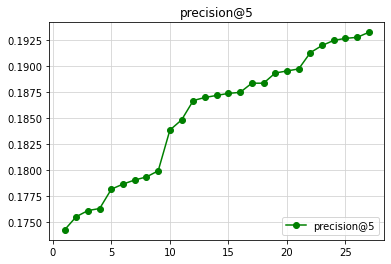

In [22]:
plt.plot(np.arange(1, len(sorted_scores)+1), sorted_scores, 'go-', label='precision@5')

plt.legend(loc="lower right")
plt.grid(color="lightgrey")
plt.title('precision@5')
plt.show()

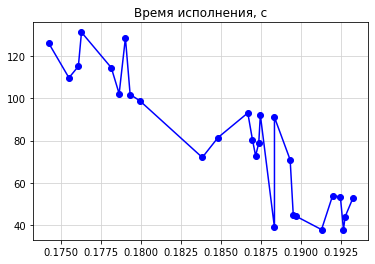

In [23]:
plt.plot(sorted_scores, sorted_times, 'bo-')

plt.grid(color="lightgrey")
plt.title('Время исполнения, с')
plt.show()

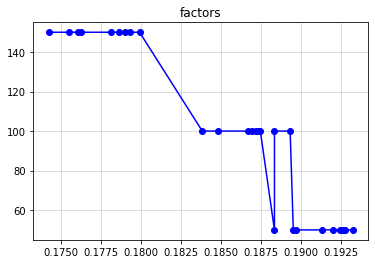

In [24]:
plt.plot(sorted_scores, sorted_factors, 'bo-')

plt.grid(color="lightgrey")
plt.title('factors')
plt.show()

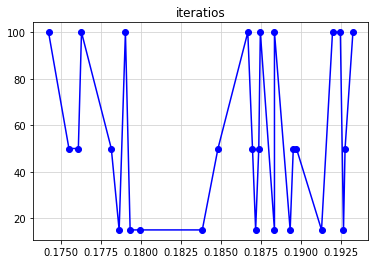

In [25]:
plt.plot(sorted_scores, sorted_iterat, 'bo-')

plt.grid(color="lightgrey")
plt.title('iteratios')
plt.show()

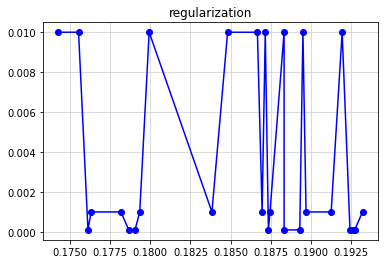

In [26]:
plt.plot(sorted_scores, sorted_reg, 'bo-')

plt.grid(color="lightgrey")
plt.title('regularization')
plt.show()

Выводы:<br>
- Изменение числа факторов находится в обратной связи с метрикой - это удивтельно. Изменеие числа факторов оказывает самое сильное влияние на метрику.
- Прямой зависимости метрики от количества итераций не установлено, тоже не очевидный результат
- Также нет прямой зависимости от величины коэффициента регуляризации.
- Нет очевидного влияния взаимного изменения гиперпараметров
- Подбор гиперпараметров оказывает умеренное влияние на метрику